In [16]:
import os
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import torch
from torch import nn,optim
from torchvision import transforms, datasets
from tqdm.notebook import tqdm

In [22]:
traindatanp = np.loadtxt("./cifar/dogs.csv",delimiter=',').reshape(5000,3,32,32)
traindatanp = traindatanp.astype('float32')
traindata = (torch.from_numpy(traindatanp)-128.0)/128.0

In [23]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [41]:
class Generative(nn.Module):
    def __init__(self):
        super(Generative, self).__init__()
        
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # state size. 256 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # state size. 128 x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # state size. 128 x 8 x 8
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. 3 x 32 x 32   
            )
    
    def forward(self, x):
        return self.main(x)
    

In [42]:
class Discriminative(nn.Module):
    def __init__(self):
        super(Discriminative, self).__init__()
        
        self.main = nn.Sequential(
                # input is 3 x 32 x 32
                nn.Conv2d(3, 64, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. 32 x 32 x 32
                nn.Conv2d(64, 128, 4, 2, 1, bias=False),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. 64 x 16 x 16
                nn.Conv2d(128, 256, 4, 2, 1, bias=False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. 128 x 8 x 8
                nn.Conv2d(256, 512, 4, 2, 1, bias=False),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. 256 x 4 x 4
                nn.Conv2d(512, 1, 2, 1, 0, bias=False),
                nn.Sigmoid()
            )
    
    def forward(self, x):
        return self.main(x)

In [47]:
lr = 0.0002

device=torch.device("cuda:0")

disc = Discriminative()
disc.apply(weights_init)
disc.cuda()
disc_optimizer = optim.Adam(params=disc.parameters(), lr=lr, betas=(0.5,0.999))

loss = nn.BCELoss()

gen = Generative()
gen.apply(weights_init)
gen.cuda()
gen_optimizer = optim.Adam(params=gen.parameters(), lr=lr, betas=(0.5,0.999))

n_epochs = 100


for e in tqdm(range(n_epochs)):
    for i in range(50):
        
        real_images = traindata[(i*100):(i+1)*100].to(device)
        
        disc_optimizer.zero_grad()

        # Define real_images, real_labels
        real_labels = torch.full((real_images.size(0),1), 1).view(100).to(device)
        # Generate noise and define fake_labels
        noise_vectors = torch.randn(real_images.size(0), 100, 1, 1).to(device)
        fake_labels = torch.full((real_images.size(0),1), 0).view(100).to(device)

        # Train discriminative network one step using batch of real images
        #real_images = real_images + (torch.randn(real_images.size())/10)
        output = disc(real_images).view(100)
        real_loss = loss(output, real_labels)
        real_loss.backward()
        disc_real_avg = output.mean().item()

        # Generate fake images from noise and pass them through disc. net.
        fake_images = gen(noise_vectors)
        #fake_images = fake_images + (torch.randn(fake_images.size())/10)
        output = disc(fake_images.detach()).view(100)
        fake_loss = loss(output, fake_labels)
        fake_loss.backward()

        # Aggregative real and fake loss and update weights
        step_loss = real_loss + fake_loss
        disc_fake_avg = output.mean().item()
        disc_optimizer.step()

        # Train generative network
        gen_optimizer.zero_grad()

        output = disc(fake_images).view(100)
        gen_loss = loss(output, real_labels)
        gen_loss.backward()
        gen_avg = output.mean().item()
        gen_optimizer.step()
        
        if i % 50 == 49:
            print("Epoch: "+str(e+1)+" | Disc. Loss: "+str(step_loss.item())+" | Gen. Loss: "+str(gen_loss.item())+
             " | D(X): "+str(disc_real_avg)+" | D(G(Z)): "+str(disc_fake_avg)+" -> "+str(gen_avg))

            


Epoch: 1 | Disc. Loss: 0.34534552693367004 | Gen. Loss: 5.011874198913574 | D(X): 0.7969087958335876 | D(G(Z)): 0.06251048296689987 -> 0.0075514791533350945
Epoch: 2 | Disc. Loss: 0.5717774629592896 | Gen. Loss: 4.199115753173828 | D(X): 0.77027428150177 | D(G(Z)): 0.20839011669158936 -> 0.02739756368100643
Epoch: 3 | Disc. Loss: 0.6491440534591675 | Gen. Loss: 3.9654388427734375 | D(X): 0.8173866271972656 | D(G(Z)): 0.320758193731308 -> 0.024000873789191246
Epoch: 4 | Disc. Loss: 1.0297809839248657 | Gen. Loss: 5.325384140014648 | D(X): 0.7050054669380188 | D(G(Z)): 0.4366621673107147 -> 0.00594486715272069
Epoch: 5 | Disc. Loss: 0.5235608816146851 | Gen. Loss: 2.9158928394317627 | D(X): 0.7520673871040344 | D(G(Z)): 0.18640029430389404 -> 0.06480788439512253
Epoch: 6 | Disc. Loss: 0.2858525514602661 | Gen. Loss: 4.0337395668029785 | D(X): 0.9003065824508667 | D(G(Z)): 0.15619798004627228 -> 0.022498242557048798
Epoch: 7 | Disc. Loss: 0.8478893041610718 | Gen. Loss: 4.460854530334473 

In [ ]:
plt.imshow(traindata[0].reshape(32,32,3).numpy())

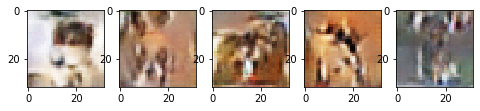

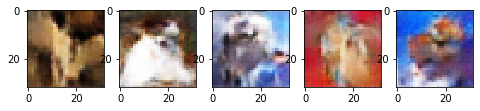

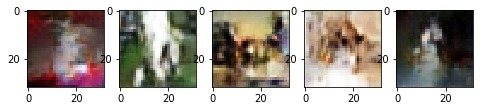

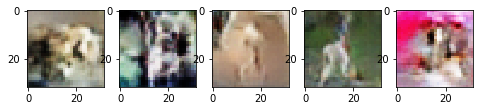

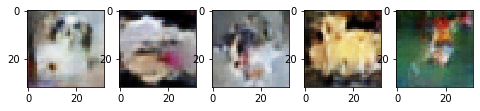

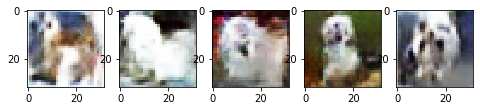

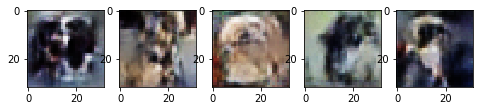

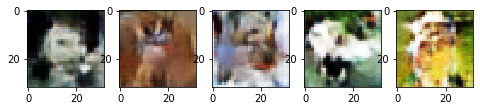

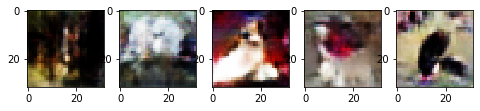

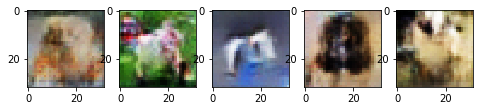

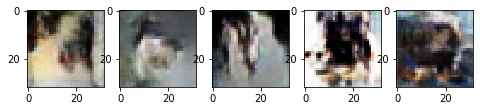

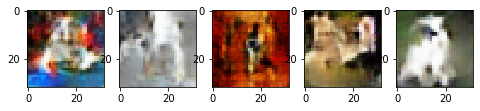

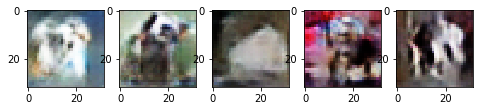

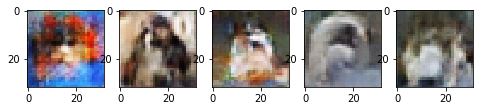

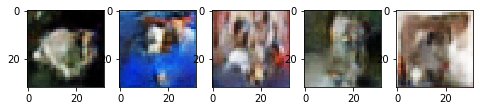

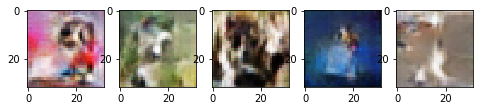

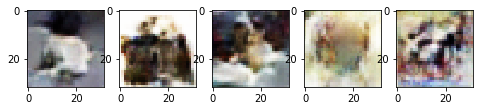

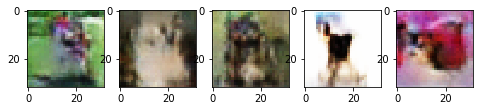

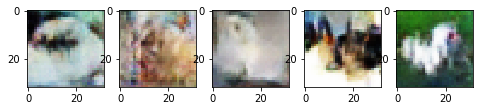

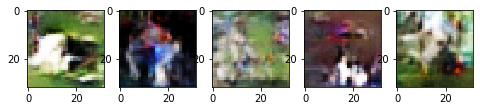

In [55]:
noise_vectors = torch.randn(real_images.size(0), 100, 1, 1).to(device)
fake_images = gen(noise_vectors)

fake_images.shape

for k in range(20):
    fig, axes = plt.subplots(1,5,figsize=(8,8))
    for j, im in enumerate(axes.flat):
        im.imshow((fake_images[5*k+j].detach().cpu().numpy().transpose(1,2,0)+1)/2)